# Nenana Ice Classic Modeling
This notebook was used for modeling the NIC data.

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime

import warnings
warnings.filterwarnings("ignore")
import gc # garbage collection

In [2]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, Normalizer
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OrdinalEncoder #TargetEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn.svm import SVC

# metrics
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

In [3]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [4]:
# read data
df = pd.read_csv('../data/cleaned_data.csv')

In [5]:
df.head()

,Unnamed: 0,Date,readingTime,weatherSummary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,...,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipType,precipAccumulation,winningTime,daylightHours,iceThickness
0,0,2009-04-01,1238572800,Partly cloudy throughout the day.,partly-cloudy-day,1238598720,1238647800,0.24,0.0,0.0,...,1238623320,-0.27,1238579940,17.69,1238608560,none,0.0,0,0.568056,45.0
1,1,2009-04-02,1238659200,Partly cloudy throughout the day.,partly-cloudy-day,1238684940,1238734380,0.27,0.0,0.0,...,1238726100,-19.98,1238684760,20.02,1238735040,none,0.0,0,0.572222,45.0
2,2,2009-04-03,1238745600,Clear throughout the day.,clear-day,1238771100,1238820960,0.31,0.0,0.0,...,1238804700,-5.11,1238773740,29.20,1238798700,none,0.0,0,0.577083,45.0
3,3,2009-04-04,1238832000,Clear throughout the day.,clear-day,1238857260,1238907540,0.34,0.0,0.0,...,1238896800,-7.95,1238859660,20.35,1238896920,none,0.0,0,0.581944,45.0
4,4,2009-04-05,1238918400,Clear throughout the day.,clear-day,1238943480,1238994120,0.38,0.0,0.0,...,1238985180,-7.83,1238929200,28.09,1238989980,none,0.0,0,0.586111,45.0


In [6]:
df.drop(columns = 'Unnamed: 0', inplace = True)

## Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         669 non-null    object 
 1   readingTime                  669 non-null    int64  
 2   weatherSummary               669 non-null    object 
 3   icon                         669 non-null    object 
 4   sunriseTime                  669 non-null    int64  
 5   sunsetTime                   669 non-null    int64  
 6   moonPhase                    669 non-null    float64
 7   precipIntensity              669 non-null    float64
 8   precipIntensityMax           669 non-null    float64
 9   precipProbability            669 non-null    float64
 10  temperatureHigh              669 non-null    float64
 11  temperatureHighTime          669 non-null    int64  
 12  temperatureLow               669 non-null    float64
 13  temperatureLowTime  

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df['winningTime'] = pd.to_datetime(df['winningTime'], errors = 'ignore')

In [10]:
# create column for ordinal day of year
df['dayOfYear'] = df['Date'].dt.dayofyear

In [11]:
# create binary 'winningDate' column
df['winningDate'] = 0
idx = df.loc[df['winningTime'] != '0'].index
df['winningDate'].loc[idx] = 1

In [12]:
# df.plot(x = 'Date', y = 'iceThickness', kind = 'scatter', figsize = (10, 6))
# df.plot(x = 'Date', y = 'temperatureMin', kind = 'scatter', figsize = (10, 6))
# plt.show();

Let's continue by dropping the columns that I don't think will help with this prediction task.

Reasoning behind dropping these columns:
* Most time features dropped were because they only captured a single, specific event (the time the daytime high temperature was recorded, for example) _thinking about this, I may go back and get hourly data; something like length of time that the temperature was high or low for a day might have an impact?_
* "apparentTemperature" features were dropped because they're a representation of what conditions feel like, not what they actually are.
* Sunrise and sunset times were dropped because that information was captured in 'daylightHours'
* "weatherSummary" and "icon" features were dropped because they're text summaries of information captured by other features.
* "precipProbability" was dropped because this is past data and the presence/amount of precipitation is known.
* "precipIntensityMax" was dropped because the precipitation rate is already captured by "precipIntensity" and I don't think knowing the maximum precipitation rate adds anything.
* "visibility" was dropped because atmospheric conditions are already captured by other features ("cloudCover," "uvIndex," "precipIntensity" to name some)
* "temperatureHigh" and "temperatureLow" were dropped because the first is the daytime high and the second is the nighttime low; the 24 hour maximum and minimum are captured by "temperatureMax" and "temperatureMin" respectively

In [13]:
df.drop(columns = ['readingTime', 'weatherSummary', 'icon', 'sunriseTime', 'sunsetTime', 'precipProbability',
                   'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLow',
                   'apparentTemperatureLowTime', 'uvIndexTime', 'apparentTemperatureMin',
                   'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime',
                   'visibility', 'precipIntensityMax', 'dewPoint',
                   'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
                   'temperatureMinTime', 'temperatureMaxTime'],
        inplace = True)

---
These features worked the best (so far) with logreg; drop all but these? experiment further first?

used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                669 non-null    datetime64[ns]
 1   moonPhase           669 non-null    float64       
 2   precipIntensity     669 non-null    float64       
 3   humidity            669 non-null    float64       
 4   atmoPressure        669 non-null    float64       
 5   windSpeed           669 non-null    float64       
 6   windGust            669 non-null    float64       
 7   windBearing         669 non-null    int64         
 8   cloudCover          669 non-null    float64       
 9   uvIndex             669 non-null    float64       
 10  temperatureMin      669 non-null    float64       
 11  temperatureMax      669 non-null    float64       
 12  precipType          669 non-null    object        
 13  precipAccumulation  669 non-null    float64       

In [15]:
df['past'] = (df['Date'] < '2017-01-01').astype(np.int)

In [16]:
df['future'] = 1 - df['past']

In [17]:
df.head().append(df.tail())

,Date,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,...,temperatureMax,precipType,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
0,2009-04-01,0.24,0.0000,0.64,1014.8,4.44,24.30,252,0.62,2.0,...,22.56,none,0.0,0,0.568056,45.0,91,0,1,0
1,2009-04-02,0.27,0.0000,0.57,1019.5,2.97,11.84,90,0.39,2.0,...,24.72,none,0.0,0,0.572222,45.0,92,0,1,0
2,2009-04-03,0.31,0.0000,0.51,1015.2,2.58,13.08,324,0.21,3.0,...,31.73,none,0.0,0,0.577083,45.0,93,0,1,0
3,2009-04-04,0.34,0.0000,0.58,1022.7,4.13,16.16,314,0.30,3.0,...,25.51,none,0.0,0,0.581944,45.0,94,0,1,0
4,2009-04-05,0.38,0.0000,0.58,1018.9,2.51,13.69,66,0.00,3.0,...,31.85,none,0.0,0,0.586111,45.0,95,0,1,0
664,2019-05-27,0.80,0.0003,0.42,1006.8,3.90,33.37,226,0.29,4.0,...,67.58,rain,0.0,0,0.827778,25.0,147,0,0,1
665,2019-05-28,0.83,0.0008,0.55,1013.8,2.27,6.06,352,0.62,4.0,...,66.95,rain,0.0,0,0.832639,25.0,148,0,0,1
666,2019-05-29,0.86,0.0001,0.51,1014.4,2.54,9.64,108,0.44,4.0,...,70.30,rain,0.0,0,0.836806,25.0,149,0,0,1
667,2019-05-30,0.89,0.0001,0.40,1011.0,2.75,11.37,99,0.41,5.0,...,74.71,rain,0.0,0,0.840972,25.0,150,0,0,1
668,2019-05-31,0.92,0.0067,0.68,1005.3,2.29,8.64,343,0.91,3.0,...,65.79,rain,0.0,0,0.845139,25.0,151,0,0,1


In [18]:
df.loc[df['winningDate'] == 1]

,Date,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,...,temperatureMax,precipType,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
30,2009-05-01,0.26,0.0000,0.30,1019.5,1.94,9.18,305,0.00,4.0,...,74.64,none,0.0,8:41 PM,0.709028,42.7,121,1,1,0
89,2010-04-29,0.56,0.0000,0.42,1004.0,2.36,23.01,176,0.58,4.0,...,63.59,none,0.0,9:06 AM,0.698611,40.9,119,1,1,0
155,2011-05-04,0.06,0.0000,0.45,1009.9,2.70,0.00,284,0.40,4.0,...,51.60,none,0.0,4:24 PM,0.720833,39.0,124,1,1,0
205,2012-04-23,0.09,0.0000,0.56,1010.7,3.82,17.21,76,0.13,4.0,...,57.97,none,0.0,7:39 PM,0.672222,28.7,114,1,1,0
293,2013-05-20,0.35,0.0000,0.33,1034.6,2.74,12.43,144,0.00,5.0,...,54.55,none,0.0,2:41 PM,0.799306,40.0,140,1,1,0
329,2014-04-25,0.89,0.0000,0.47,999.1,4.51,22.92,142,0.33,4.0,...,54.33,none,0.0,3:48 PM,0.679861,36.5,115,1,1,0
389,2015-04-24,0.23,0.0000,0.27,1006.1,3.12,11.17,109,0.00,4.0,...,56.60,none,0.0,2:25 PM,0.673611,36.5,114,1,1,0
449,2016-04-23,0.56,0.0000,0.47,1004.0,3.44,9.71,321,0.41,4.0,...,59.60,none,0.0,3:39 PM,0.672222,32.3,114,1,1,0
518,2017-05-01,0.22,0.0000,0.44,1005.8,3.88,11.00,107,0.12,4.0,...,56.54,none,0.0,12:00 PM,0.709028,29.7,121,1,0,1
579,2018-05-01,0.57,0.0005,0.70,1007.4,5.14,11.89,226,0.91,3.0,...,43.57,rain,0.0,1:18 PM,0.707639,25.0,121,1,0,1


In [19]:
df['precipType'].value_counts()

none    541
rain     89
snow     39
Name: precipType, dtype: int64

In [20]:
# encode precipType
df = df.merge(pd.get_dummies(df['precipType'], prefix = 'precip', drop_first = True, sparse = True),
         how = 'left', left_index = True, right_index = True)

Create column for daily average temperature

In [21]:
df['temperatureAvg'] = (df['temperatureMin'] + df['temperatureMax']) / 2

Create columns for number of "hot days," "cold days," and snow accumulated since Apr 1 in a given year.

I defined a "hot day" as a day where: day_average_temp > median(year_avg_temp) + std_dev(year_avg_temp)

A "cold day" is a day where: day_average_temp < median(year_avg_temp) - std_dev(year_avg_temp)

In [22]:
year_list = sorted(list(set(df['Date'].dt.year)))

In [23]:
year_list

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [24]:
hot_count = []
cold_count = []
daily_accumulation = []
for year in year_list:
    hot_temp_count = 0
    cold_temp_count = 0
    daily_accum = 0
    temp_df = df.loc[df['Date'].dt.year == year]
    hot_threshold = temp_df['temperatureAvg'].median() + temp_df['temperatureAvg'].std()
    cold_threshold = temp_df['temperatureAvg'].median() - temp_df['temperatureAvg'].std()
    for idx in temp_df.index:
        current_temp = temp_df['temperatureAvg'].loc[idx]
        if temp_df['precip_snow'].loc[idx] == 1:
            daily_accum += temp_df['precipAccumulation'].loc[idx]
        else:
            pass
        if current_temp >= hot_threshold:
            hot_temp_count += 1
        elif current_temp <= cold_threshold:
            cold_temp_count += 1
        else:
            pass
        hot_count.append(hot_temp_count)
        cold_count.append(cold_temp_count)
        daily_accumulation.append(daily_accum)

In [25]:
df['numHotDays'] = hot_count
df['numColdDays'] = cold_count
df['accumulatedSnow'] = daily_accumulation

In [26]:
df.shape

(669, 27)

In [27]:
df['noise_test'] = np.random.random_sample(669)

## Modeling

In [128]:
# the thing to beat: 0.9835575485799701
1 - (df['winningDate'].sum()/df['winningDate'].count())

0.9835575485799701

In [28]:
df_past = df.loc[df['past'] == 1]
df_past.drop(columns = ['past', 'future'], inplace = True)

In [29]:
df_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                488 non-null    datetime64[ns]  
 1   moonPhase           488 non-null    float64         
 2   precipIntensity     488 non-null    float64         
 3   humidity            488 non-null    float64         
 4   atmoPressure        488 non-null    float64         
 5   windSpeed           488 non-null    float64         
 6   windGust            488 non-null    float64         
 7   windBearing         488 non-null    int64           
 8   cloudCover          488 non-null    float64         
 9   uvIndex             488 non-null    float64         
 10  temperatureMin      488 non-null    float64         
 11  temperatureMax      488 non-null    float64         
 12  precipType          488 non-null    object          
 13  precipAccumulation  

In [30]:
df_future = df.loc[df['future'] == 1]
df_future.drop(columns = ['past', 'future'], inplace = True)

In [31]:
df_future.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 488 to 668
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                181 non-null    datetime64[ns]  
 1   moonPhase           181 non-null    float64         
 2   precipIntensity     181 non-null    float64         
 3   humidity            181 non-null    float64         
 4   atmoPressure        181 non-null    float64         
 5   windSpeed           181 non-null    float64         
 6   windGust            181 non-null    float64         
 7   windBearing         181 non-null    int64           
 8   cloudCover          181 non-null    float64         
 9   uvIndex             181 non-null    float64         
 10  temperatureMin      181 non-null    float64         
 11  temperatureMax      181 non-null    float64         
 12  precipType          181 non-null    object          
 13  precipAccumulation

In [32]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

11

In [33]:
exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'moonPhase']
# exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'moonPhase', 'atmoPressure', 'windSpeed',
#            'windGust', 'windBearing', 'cloudCover', 'temperatureMin', 'temperatureMax', 'precipAccumulation',
#            'precip_rain', 'precip_snow']

In [34]:
# used_cols = [c for c in df_past.columns if c not in exclude]
used_cols = ['numHotDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'humidity', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_validate(pipe, X, y, cv = 5, scoring=['f1_weighted',
                                                     'precision_weighted',
                                                     'recall_weighted',
                                                     'roc_auc'])
# scores.mean(), scores.std()
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# ['numHotDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'humidity', 'accumulatedSnow']
# f1_weighted: 0.8915670081204933 +/- 0.06123258543477035
# precision_weighted: 0.9733500280804396 +/- 0.014326405171511956
# recall_weighted: 0.8356196086682095 +/- 0.10597665011938112
# roc_auc: 0.8473958333333333 +/- 0.07621982554136132

f1_weighted: 0.8915670081204933 +/- 0.06123258543477035
precision_weighted: 0.9733500280804396 +/- 0.014326405171511956
recall_weighted: 0.8356196086682095 +/- 0.10597665011938112
roc_auc: 0.8473958333333333 +/- 0.07621982554136132


In [35]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kbinsdiscretizer',
                 KBinsDiscretizer(encode='ordinal', n_bins=7,
                                  strategy='quantile')),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=False,
                                     func=<function stringify at 0x1a1d651c80>,
                                     inv_kw_ar...
                            verbose=0)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight='balanced',
                                      cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
        

In [36]:
for n, v in enumerate(clf_lr.coef_[0]):
    print(n, v)

0 5.194063092631059
1 5.722118482355292
2 3.6811568295544888
3 2.161227473291987
4 5.342840106202216
5 2.366261294754751


In [37]:
for n, v in enumerate(used_cols):
    print(n, v)

0 numHotDays
1 iceThickness
2 dayOfYear
3 uvIndex
4 humidity
5 accumulatedSnow


#### Metrics defined
* F1 = harmonic mean of precision and recall (2 * (precision * recall / precision + recall))
* precision = correct_pos_preds / total_pos_preds (percent correct of all positive predictions; positive predictive power)
* recall = correct_pos_preds / total_actual_positives (True Positive Rate)
* roc_auc = https://en.wikipedia.org/wiki/Receiver_operating_characteristic (TPR vs TNR at a threshold)

In [38]:
used_cols

['numHotDays',
 'iceThickness',
 'dayOfYear',
 'uvIndex',
 'humidity',
 'accumulatedSnow']

In [39]:
pipe.fit(X, y)
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

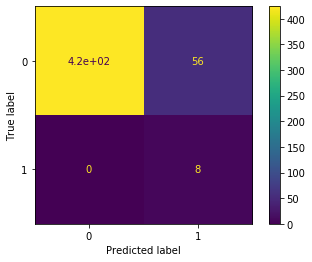

In [40]:
metrics.plot_confusion_matrix(pipe, X, y);

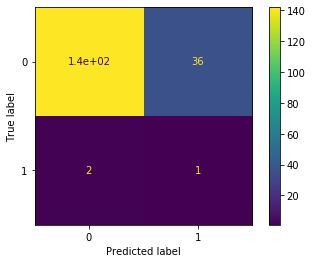

In [41]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [42]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([3.08957684e-04, 3.08957684e-04, 4.06116280e-07, 5.19387188e-04,
       8.12051207e-05])

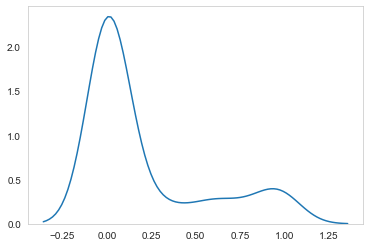

In [43]:
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(y_pred);

In [44]:
metrics.confusion_matrix(y_test, y_pred > 0.01)

array([[105,  73],
       [  2,   1]])

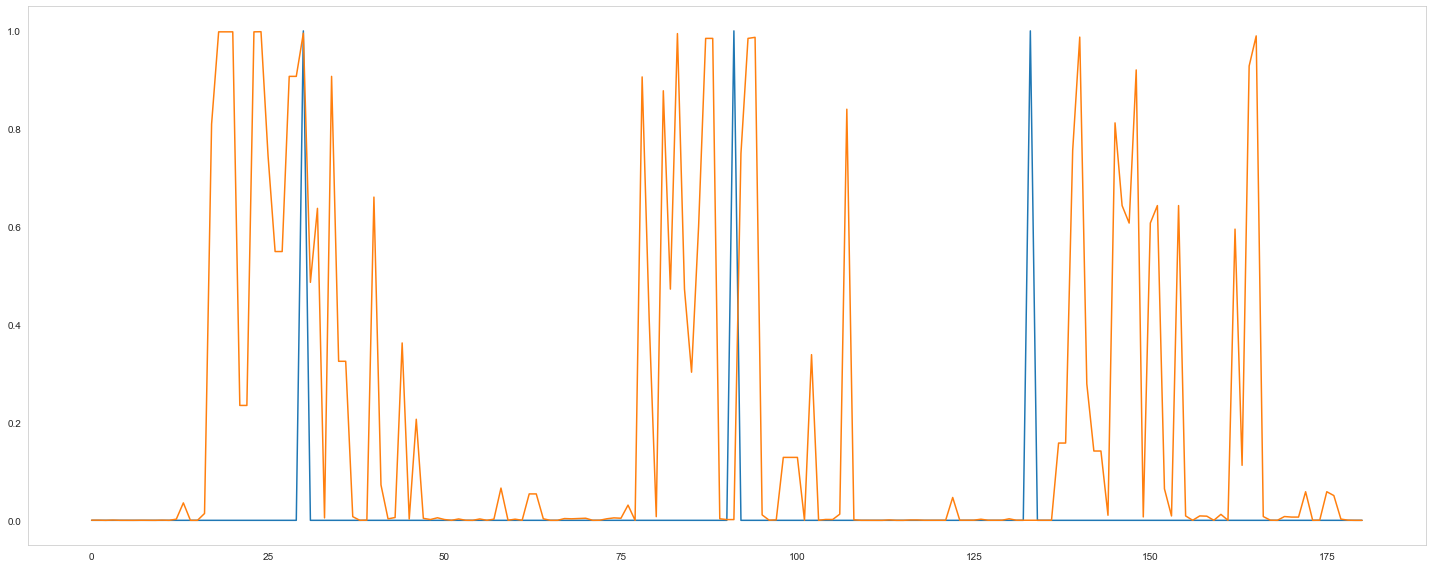

In [45]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.show()

In [46]:
exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'moonPhase', 'windSpeed',
           'windGust', 'windBearing', 'temperatureMin', 'temperatureMax', 'precipAccumulation',
           'precip_rain', 'precip_snow', 'noise_test']
used_cols = [c for c in df_past.columns if c not in exclude]
# used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_svc = SVC(C = 1000,
              kernel = 'linear',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)
# pipe = make_pipeline(scaler, binner, objectify, encoder, clf_svc)
pipe = make_pipeline(scaler, clf_svc)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_validate(pipe, X, y, cv = TimeSeriesSplit(), scoring=['f1_weighted',
                                                                     'precision_weighted',
                                                                     'recall_weighted',
                                                                     'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: 0.8554557229821034 +/- 0.0819622236416445
precision_weighted: 0.9724738320541684 +/- 0.014663679036231368
recall_weighted: 0.782716049382716 +/- 0.13492420831915308
roc_auc: 0.7738924050632912 +/- 0.18539915560631698


In [47]:
used_cols

['precipIntensity',
 'humidity',
 'atmoPressure',
 'cloudCover',
 'uvIndex',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']

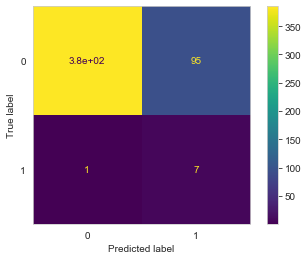

In [48]:
pipe.fit(X, y)
metrics.plot_confusion_matrix(pipe, X, y);

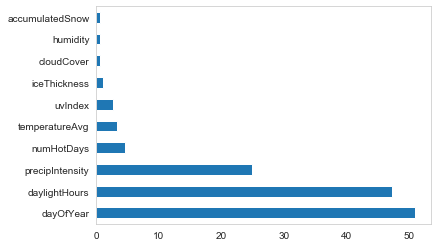

In [49]:
pd.Series(abs(clf_svc.coef_[0]), index=df_past[used_cols].columns).nlargest(10).plot(kind='barh')

In [50]:
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

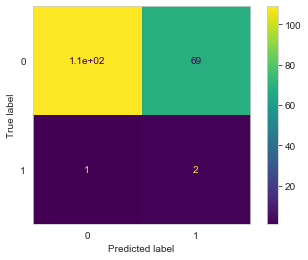

In [51]:
metrics.plot_confusion_matrix(pipe, X_test, y_test)

In [52]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.026163  , 0.02749843, 0.02455515, 0.02927944, 0.02604433])

In [53]:
metrics.confusion_matrix(y_test, y_pred > 0.021)

array([[79, 99],
       [ 0,  3]])

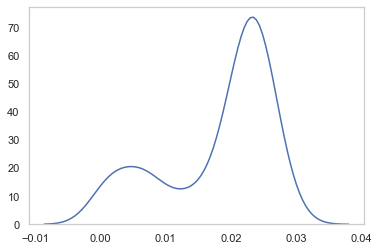

In [54]:
import seaborn as sns; sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(y_pred);

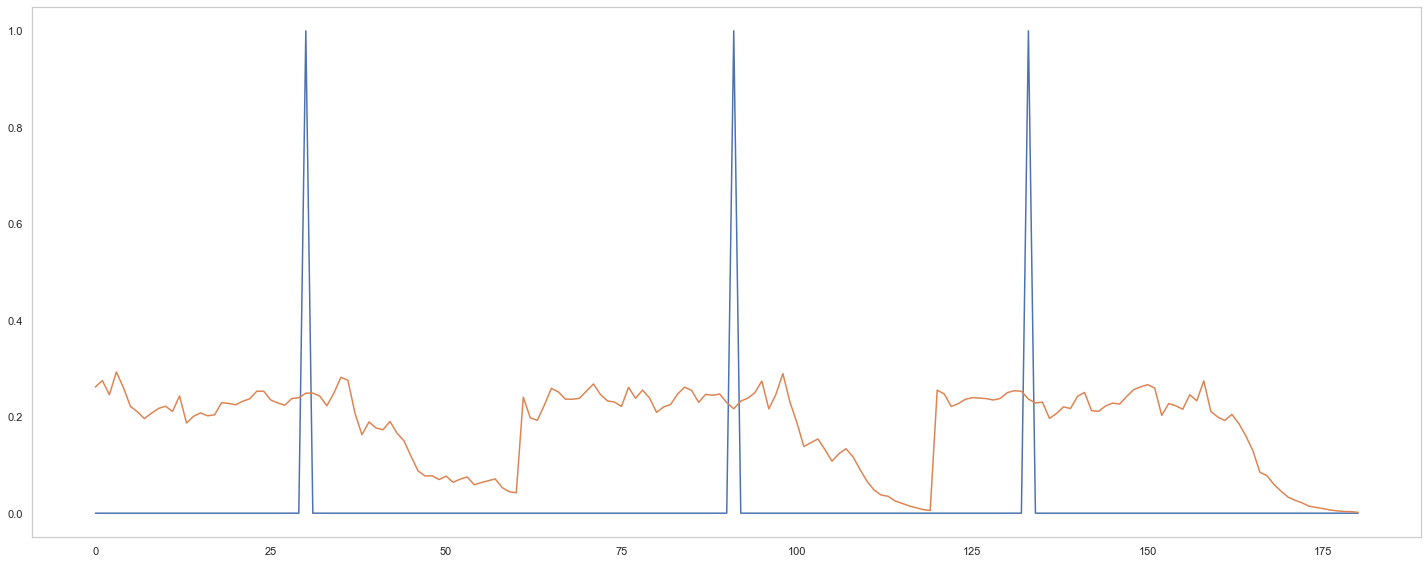

In [55]:
# plot of target vs predicted probability (multiplied by 10 so it was easier to see)
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(10*y_pred)
plt.tight_layout()
plt.show()

_Notes_
* add feature for day-of-year (to make the models time-aware) [x];
* try hidden Markov model;
* look at survival analysis/time-to-event analysis [x];
* look for outliers in training data, if removed, does model performance improve?;
* is there any way to identify mechanical failure of ice vs mush-out?;
* more time-series-like features, for instance number of "hot" days vs number of "cold" days [x];
* consider under- or over-sampling

survival analysis: https://lifelines.readthedocs.io/en/latest/

Kaggle competition modeling time-to-event: https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94484

### Survival Analysis Application
Looked at from survival analysis point-of-view:

Each daily observation could be viewed like this:
* "birth": start of day with ice intact
* "death": end of day with ice intact
* Censored: ice breaks before end of day
  * there will be 11 censored observations here
  
  If I do it this way, max lifespan will be 1 day; there will be 11 censored observations and I will need to calculate the duration for those; I think I will need to truncate the annual data after the censored observation since the ice will no longer be intact.

Another way to look at it:
* "birth": start of day with ice intact
* "death": ice breaks
* Censored: end of day with ice intact
  * there will be ~660 censored observations here
  
  Done this way, max lifespan is still 1 day; there will be 660-ish censored observations; I still need to calculate actual duration for the "deaths"; still need to truncate the annual data after the "death"

look at it on a yearly basis instead of daily basis:
* "birth": start of observed period with ice intact
* "death": end of observed period with ice intact
* Censored: ice breaks before end of observed period
  * there will be 0 observations here, so I don't think this one is valid

OR
* "birth": start of observed period
* "death": ice breaks
* Censored: observed period ends with ice intact
  * there will be 0 censored observations here
  * I think this is the most promising
    * Y is % survival
    * X is day of year

In [56]:
df_survival = pd.read_csv('../data/ice_classic_winning_times.csv')

In [57]:
df_survival.head()

,Date,Time
0,1917-04-30,11:30 AM
1,1918-05-11,9:33 AM
2,1919-05-03,2:33 PM
3,1920-05-11,10:46 AM
4,1921-05-11,6:42 AM


In [58]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    103 non-null    object
 1   Time    103 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [59]:
df_survival['Time'] = df_survival['Date'] + ' ' + df_survival['Time']
df_survival['Date'] = pd.to_datetime(df_survival['Date'])
df_survival['Time'] = pd.to_datetime(df_survival['Time'])

In [60]:
df_survival['day_of_year'] = df_survival['Date'].dt.dayofyear

In [61]:
df_survival['observed'] = 1

In [62]:
df_survival['observation_entry'] = 91

In [63]:
df_survival.head()

,Date,Time,day_of_year,observed,observation_entry
0,1917-04-30,1917-04-30 11:30:00,120,1,91
1,1918-05-11,1918-05-11 09:33:00,131,1,91
2,1919-05-03,1919-05-03 14:33:00,123,1,91
3,1920-05-11,1920-05-11 10:46:00,132,1,91
4,1921-05-11,1921-05-11 06:42:00,131,1,91


In [64]:
from lifelines import ( KaplanMeierFitter, WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter,
PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter, CoxPHFitter)

from lifelines.plotting import plot_lifetimes
from lifelines.utils import datetimes_to_durations

In [65]:
# create knots for lifelines spline fitter
surv_min = df_survival['day_of_year'].min()
surv_1q = df_survival['day_of_year'].quantile(0.25)
surv_med = df_survival['day_of_year'].median()
surv_3q = df_survival['day_of_year'].quantile(0.75)
surv_max = df_survival['day_of_year'].max()

In [66]:
mod_kmf = KaplanMeierFitter()
mod_wbf = WeibullFitter()
mod_exf = ExponentialFitter()
mod_lnf = LogNormalFitter()
mod_naf = NelsonAalenFitter()
mod_llf = LogLogisticFitter()
mod_pwf = PiecewiseExponentialFitter([120, 135])
mod_gg = GeneralizedGammaFitter()
mod_spf = SplineFitter([surv_min, surv_1q, surv_med, surv_3q, surv_max])

In [67]:
T = df_survival['day_of_year']
E = df_survival['observed']

mod_kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 103 total observations, 0 right-censored observations>

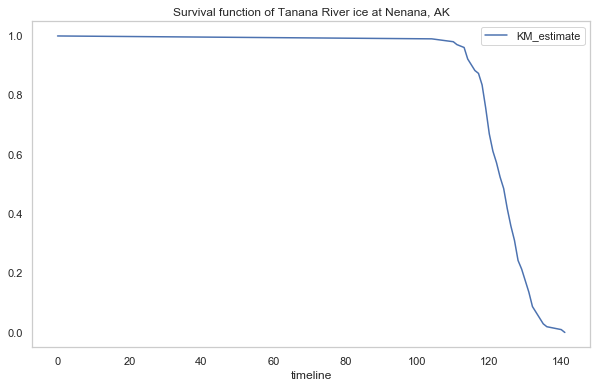

In [68]:
mod_kmf.survival_function_.plot(figsize = (10,6))
plt.title('Survival function of Tanana River ice at Nenana, AK');

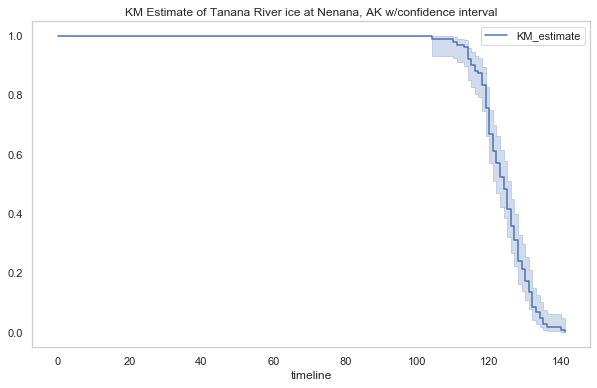

In [69]:
mod_kmf.plot(figsize = (10,6));
plt.title('KM Estimate of Tanana River ice at Nenana, AK w/confidence interval');

In [70]:
mod_kmf.median_survival_time_

124.0

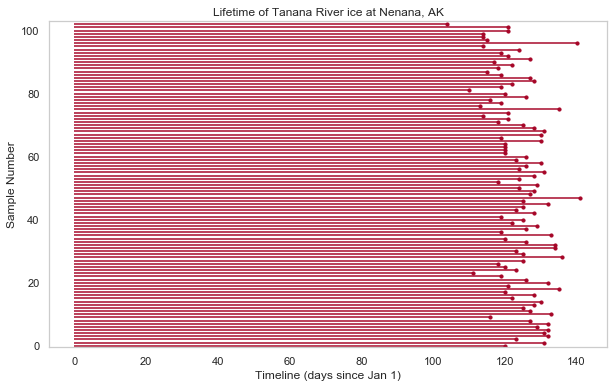

In [71]:
plt.figure(figsize = (10, 6))
plot_lifetimes(durations = df_survival['day_of_year'],
               event_observed = df_survival['observed'])
plt.xlabel('Timeline (days since Jan 1)')
plt.ylabel('Sample Number')
plt.title('Lifetime of Tanana River ice at Nenana, AK');

In [72]:
wf = mod_wbf.fit(T, E)

wf.print_summary()

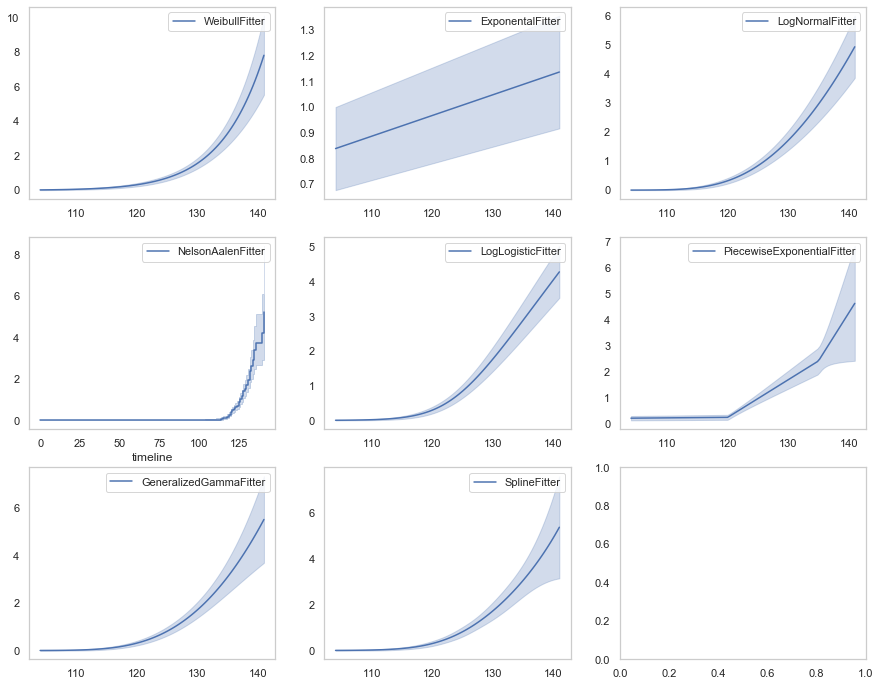

In [73]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf = mod_wbf.fit(T, E, label='WeibullFitter')
exf = mod_exf.fit(T, E, label='ExponentalFitter')
lnf = mod_lnf.fit(T, E, label='LogNormalFitter')
kmf = mod_kmf.fit(T, E, label ='KaplanMeierFitter')
naf = mod_naf.fit(T, E, label='NelsonAalenFitter')
llf = mod_llf.fit(T, E, label='LogLogisticFitter')
pwf = mod_pwf.fit(T, E, label='PiecewiseExponentialFitter')
gg = mod_gg.fit(T, E, label='GeneralizedGammaFitter')
spf = mod_spf.fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])
gg.plot_cumulative_hazard(ax=axes[2][0])
spf.plot_cumulative_hazard(ax=axes[2][1]);

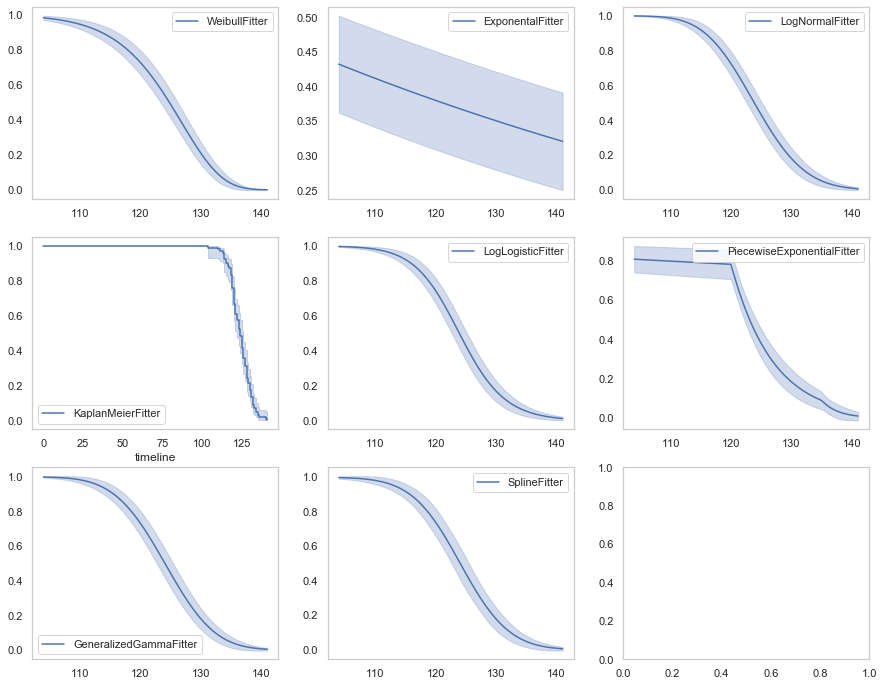

In [74]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1]);

In [75]:
df_survival

,Date,Time,day_of_year,observed,observation_entry
0,1917-04-30,1917-04-30 11:30:00,120,1,91
1,1918-05-11,1918-05-11 09:33:00,131,1,91
2,1919-05-03,1919-05-03 14:33:00,123,1,91
3,1920-05-11,1920-05-11 10:46:00,132,1,91
4,1921-05-11,1921-05-11 06:42:00,131,1,91
...,...,...,...,...,...
98,2015-04-24,2015-04-24 14:25:00,114,1,91
99,2016-04-23,2016-04-23 15:39:00,114,1,91
100,2017-05-01,2017-05-01 12:00:00,121,1,91
101,2018-05-01,2018-05-01 13:18:00,121,1,91


_Example:_
"""
     week  arrest  fin  age  race  wexp  mar  paro  prio
0      20       1    0   27     1     0    0     1     3
1      17       1    0   18     1     0    0     1     8
2      25       1    0   19     0     1    0     1    13
3      52       0    1   23     1     1    1     1     1
"""
The week column is the duration, the arrest column is the event occurred, and the other columns represent variables we wish to regress against.

['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']


Use past & future sets for splits

_(before doing all these experiments manually, might want to consider using RFE or similar)_

Experiment 1:
| date | day_of_year | duration | break_observed | cold_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 2:
| date | day_of_year | duration | break_observed | hot_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 3:
| date | day_of_year | duration | break_observed | cold_days | avg_temp | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|---|

Experiment 4:
| date | day_of_year | duration | break_observed | hot_days | avg_temp | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|


| date | day_of_year | duration | break_observed | hot_days | cold_days | avg_temp? | min_temp? | max_temp? | ice_thickness | uv_index | precip_intensity | precip_accumulation? | humidity? |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|

In [76]:
df_past.columns

Index(['Date', 'moonPhase', 'precipIntensity', 'humidity', 'atmoPressure',
       'windSpeed', 'windGust', 'windBearing', 'cloudCover', 'uvIndex',
       'temperatureMin', 'temperatureMax', 'precipType', 'precipAccumulation',
       'winningTime', 'daylightHours', 'iceThickness', 'dayOfYear',
       'winningDate', 'precip_rain', 'precip_snow', 'temperatureAvg',
       'numHotDays', 'numColdDays', 'accumulatedSnow', 'noise_test'],
      dtype='object')

In [77]:
# df_past_surv = df_past.copy()

In [78]:
# df_past_surv.drop(columns = ['moonPhase', 'atmoPressure', 'windSpeed', 'windGust', 'windBearing', 'cloudCover',
#                   'precipType', 'precipAccumulation', 'precip_rain', 'precip_snow', 'noise_test'],
#                   inplace = True)

In [79]:
# df_past_surv['duration'] = 1

In [80]:
# df_past_surv['winningTime'].value_counts()

In [81]:
# idx_w = df_past_surv.loc[df_past_surv['winningDate'] == 1].index
# idx_w

In [82]:
# df_past_surv.loc[idx_w]['winningTime']

In [83]:
# for row in idx_w:
#     win_time = df_past_surv.loc[row]['winningTime']
#     win_time = pd.to_datetime(win_time)
#     dur = win_time.minute + win_time.hour * 60
#     dur_pcnt = dur / 1440
#     df_past_surv['duration'].loc[row] = dur_pcnt

Experiment 1:
| date | day_of_year | duration | break_observed | cold_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

Experiment 2:
| date | day_of_year | duration | break_observed | hot_days | ice_thickness | uv_index | precip_intensity | precip_accumulation |
|---|---|---|---|---|---|---|---|---|

In [84]:
# df_past_surv.columns

In [85]:
# years = [year for year in range(2009, 2017)]
# drop_index = []
# for i, year in enumerate(years):
#     idx_y = df_past_surv.loc[df_past_surv['Date'].dt.year == year].index
#     for idx in idx_y:
#         if idx > idx_w[i]:
#             drop_index.append(idx)
#         else:
#             pass

In [86]:
# for idx in drop_index:
#     df_past_surv.drop(index = idx, inplace = True)

In [87]:
# df_past_surv['numHotDays'].value_counts()

I drop the 'numHotDays' columns from df_past_surv since all values are 0.

In [88]:
# df_past_surv.drop(columns = 'numHotDays', inplace = True)

In [89]:
# df_past_surv.corr()

In [90]:
# # drop_cols = ['Date', 'humidity', 'temperatureMin', 'temperatureMax', 'winningTime', 'daylightHours', 'precipIntensity']
# drop_cols = ['Date', 'winningTime', 'temperatureMin', 'temperatureMax', 'precipIntensity']
# X = df_past_surv.drop(columns = drop_cols)
# dur = df_past_surv['duration']
# obs = df_past_surv['winningDate']

# cph = CoxPHFitter()
# cph.fit(X, duration_col='duration', event_col='winningDate')

# cph.print_summary()  # access the results using cph.summary
# cph.plot();

In [91]:
# prediction examples, X is the dataset
# cph.predict_partial_hazard(X)
# cph.predict_survival_function(X)
# cph.predict_median(X)

# filter down to censored observations to predict further survival
# censored_subjects = X.loc[~obs.astype(bool)]
# censored_subjects_last_obs = censored_subjects['duration']

# cph.predict_survival_function(censored_subjects,
#                               times=[5., 25., 50.],
#                               conditional_after=censored_subjects_last_obs)
# cph.predict_median(censored_subjects,
#                    conditional_after=censored_subjects_last_obs)

In [92]:
# T = df_past_surv['duration']
# E = df_past_surv['winningDate']

In [93]:
# fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# wbf = mod_wbf.fit(T, E, label='WeibullFitter')
# exf = mod_exf.fit(T, E, label='ExponentalFitter')
# lnf = mod_lnf.fit(T, E, label='LogNormalFitter')
# kmf = mod_kmf.fit(T, E, label ='KaplanMeierFitter')
# naf = mod_naf.fit(T, E, label='NelsonAalenFitter')
# llf = mod_llf.fit(T, E, label='LogLogisticFitter')
# pwf = mod_pwf.fit(T, E, label='PiecewiseExponentialFitter')
# gg = mod_gg.fit(T, E, label='GeneralizedGammaFitter')
# spf = mod_spf.fit(T, E, label='SplineFitter')

# wbf.plot_cumulative_hazard(ax=axes[0][0])
# exf.plot_cumulative_hazard(ax=axes[0][1])
# lnf.plot_cumulative_hazard(ax=axes[0][2])
# naf.plot_cumulative_hazard(ax=axes[1][0])
# llf.plot_cumulative_hazard(ax=axes[1][1])
# pwf.plot_cumulative_hazard(ax=axes[1][2])
# gg.plot_cumulative_hazard(ax=axes[2][0])
# spf.plot_cumulative_hazard(ax=axes[2][1]);

In [94]:
# fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# wbf.plot_survival_function(ax=axes[0][0])
# exf.plot_survival_function(ax=axes[0][1])
# lnf.plot_survival_function(ax=axes[0][2])
# kmf.plot_survival_function(ax=axes[1][0])
# llf.plot_survival_function(ax=axes[1][1])
# pwf.plot_survival_function(ax=axes[1][2])
# gg.plot_survival_function(ax=axes[2][0])
# spf.plot_survival_function(ax=axes[2][1]);

In [95]:
df_survival['past'] = (df_survival['Date'] < '2015-01-01').astype(np.int)
df_survival['future'] = 1 - df_survival['past']

In [96]:
df_survival.head()

,Date,Time,day_of_year,observed,observation_entry,past,future
0,1917-04-30,1917-04-30 11:30:00,120,1,91,1,0
1,1918-05-11,1918-05-11 09:33:00,131,1,91,1,0
2,1919-05-03,1919-05-03 14:33:00,123,1,91,1,0
3,1920-05-11,1920-05-11 10:46:00,132,1,91,1,0
4,1921-05-11,1921-05-11 06:42:00,131,1,91,1,0


In [97]:
drop_cols = ['Date', 'Time', 'past', 'future']
X_past = df_survival.loc[df_survival['past'] == 1].drop(columns = drop_cols)

In [98]:
T_p = X_past['day_of_year']
E_p = X_past['observed']

In [99]:
cph = CoxPHFitter()

In [100]:
X_future = df_survival.loc[df_survival['future'] == 1].drop(columns = drop_cols)
T_f = X_future['day_of_year']
E_f = X_future['observed']

In [152]:
exclude = ['Date', 'moonPhase', 'atmoPressure', 'windSpeed', 'windGust', 'windBearing', 'precip_rain',
           'precip_snow', 'noise_test', 'precipType', 'winningTime', 'numHotDays', 'temperatureMin',
           'temperatureMax', 'precipAccumulation']
X_train = df_past.drop(columns = exclude)
X_test = df_future.drop(columns = exclude)

In [122]:
test = cph.fit(X_train, 'dayOfYear', 'winningDate')

In [123]:
test.score_

0.9970617042115573

In [104]:
test.print_summary()

In [143]:
np.random.seed(seed = 42)

In [172]:
from lifelines.utils import k_fold_cross_validation

cph = CoxPHFitter()
scores = k_fold_cross_validation(cph, X_train, 'dayOfYear', event_col='winningDate', k=5)
print(np.mean(scores), '+/-', np.std(scores))

0.9930176077717061 +/- 0.008578012392203693


In [186]:
models = []
for i in range(10):
    cph = CoxPHFitter()
    models.append(cph)
    
predictions = []
for model in models:
    model.fit(X_train, 'dayOfYear')
    pred = model.predict_expectation(X_test)
    predictions.append(pred.values)
    
np.mean(predictions), np.std(predictions)

(30.04389811421404, 17.538520247866234)

In [193]:
predictions = []
for model in models:
    model.fit(X_train, 'dayOfYear')
    pred = model.predict_survival_function(X_test)
    predictions.append(pred.values)
    
predictions[0]

array([[7.86560696e-01, 9.48003908e-01, 9.78992699e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.96873581e-01, 7.63301746e-01, 8.98170421e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [6.30969498e-03, 3.24120579e-01, 6.38927522e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.26810301e-01, 5.73691731e-01, 8.55879580e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.54011387e-04, 9.42224160e-02, 5.16047254e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.45823335e-15, 1.63433157e-04, 8.69887618e-02]])

In [199]:
predictions[0][0,:].shape

(181,)

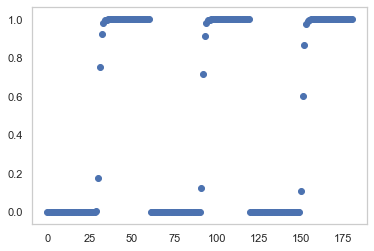

In [207]:
plt.scatter(range(181), predictions[0][31,:])